In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-tmwu18xm because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
df_patients = pd.read_csv('data/diabetic_data_processed_2.csv',index_col='patient_nbr')
df_patients.shape

(69990, 84)

In [3]:
X = df_patients.drop('readmitted',axis=1)
y = df_patients['readmitted']
X.shape, y.shape

((69990, 83), (69990,))

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
                                            X, y, 
                                            random_state=109,
                                            stratify=y,                                          
                                            test_size = 0.2 
                                            )
X_train.shape,y_train.shape, X_test.shape, y_test.shape

((55992, 83), (55992,), (13998, 83), (13998,))

In [5]:
qual_cols = [cname for cname in X_train.columns if X_train[cname].dtype == "object"]
quant_cols = [cname for cname in X_train.columns if X_train[cname].dtype != "object"]

In [6]:
#custom transformer code based on A. Geron Book by O'Reilly 
class PrepQuant(BaseEstimator, TransformerMixin):
    
    def __init__(self, corr_threshold=0.85, cardinality_threshold=10):
        self.corr_threshold=corr_threshold
        self.cardinality_threshold=cardinality_threshold
    
    def fit(self, X, y=None):
        #source: stackoverflow
        corr_matrix = X.corr().abs()
        # Select upper triangle of correlation matrix
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        self.corr_cols = [column for column in upper.columns if any(upper[column] >= self.corr_threshold)] 
        
        self.high_cardinal_cols = [col for col in X.columns if X[col].nunique()>self.cardinality_threshold]
        
        return self
    
    def transform(self, X):
            
        X.drop(self.corr_cols, axis=1, inplace=True)
        
        #log Transformation is done here not because Logistic Regression
        #depends on it but to reduce the effects of outliers
        for col in X.columns:
            if col in self.high_cardinal_cols:
                X['log_'+col]=np.log1p(X[col])
                X.drop(col,axis=1,inplace=True)
        self.columns = X.columns
        return X
                
    def get_feature_names_out(self, *args, **params):
        return self.columns

In [7]:
quant_pipeline = make_pipeline(PrepQuant(), StandardScaler())
ct = ColumnTransformer([('ohe',OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'),
                         qual_cols),
                       ('quant',quant_pipeline,quant_cols)])

ct.set_output(transform='pandas')
X_train_transformed = ct.fit_transform(X_train)

In [8]:
pd.set_option('display.max_rows', None)
display(X_train_transformed.dtypes)
X_train_transformed.describe()

ohe__race_Asian                                  float64
ohe__race_Caucasian                              float64
ohe__race_Hispanic                               float64
ohe__race_Other                                  float64
ohe__race_UNK                                    float64
ohe__gender_Male                                 float64
ohe__gender_Unknown/Invalid                      float64
ohe__age_[50-60)                                 float64
ohe__age_[60-70)                                 float64
ohe__age_[70-80)                                 float64
ohe__age_[80-100)                                float64
ohe__admission_type_id_Emergency                 float64
ohe__admission_type_id_Other                     float64
ohe__admission_type_id_Urgent                    float64
ohe__discharge_disposition_id_Home w/ Service    float64
ohe__discharge_disposition_id_Other              float64
ohe__discharge_disposition_id_SNF                float64
ohe__admission_source_id_Other 

,ohe__race_Asian,ohe__race_Caucasian,ohe__race_Hispanic,ohe__race_Other,ohe__race_UNK,ohe__gender_Male,ohe__gender_Unknown/Invalid,ohe__age_[50-60),ohe__age_[60-70),ohe__age_[70-80),...,quant__log_num_encounters,quant__log_avg_time_in_hospital,quant__log_avg_num_lab_procedures,quant__log_avg_num_procedures,quant__log_avg_times_glu_high,quant__log_avg_times_a1c_high,quant__log_avg_times_med_changed,quant__log_num_times_med_changed,quant__log_avg_times_readmitted,quant__log_num_times_readmitted
count,55992.000000,55992.000000,55992.000000,55992.000000,55992.000000,55992.000000,55992.000000,55992.000000,55992.000000,55992.000000,...,5.599200e+04,5.599200e+04,5.599200e+04,5.599200e+04,5.599200e+04,5.599200e+04,5.599200e+04,5.599200e+04,5.599200e+04,5.599200e+04
mean,0.007197,0.747464,0.021467,0.016199,0.026504,0.467995,0.000054,0.175329,0.222425,0.252625,...,2.538015e-17,6.141997e-17,1.233475e-16,4.822229e-17,1.015206e-17,4.111585e-17,3.680122e-17,3.147139e-17,2.449185e-17,6.700360e-17
std,0.084533,0.434471,0.144938,0.126240,0.160629,0.498979,0.007320,0.380251,0.415879,0.434522,...,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-5.006601e-01,-5.214612e-01,-5.387316e-01,-3.709367e-01,-9.275668e-02,-1.884234e-01,-3.743728e-01,-3.569412e-01,-2.833410e-01,-2.867640e-01
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-5.006601e-01,-5.214612e-01,-5.387316e-01,-3.709367e-01,-9.275668e-02,-1.884234e-01,-3.743728e-01,-3.569412e-01,-2.833410e-01,-2.867640e-01
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-5.006601e-01,-5.214612e-01,-5.387316e-01,-3.709367e-01,-9.275668e-02,-1.884234e-01,-3.743728e-01,-3.569412e-01,-2.833410e-01,-2.867640e-01
75%,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,...,-5.006601e-01,-5.214612e-01,-5.387316e-01,-3.709367e-01,-9.275668e-02,-1.884234e-01,-3.743728e-01,-3.569412e-01,-2.833410e-01,-2.867640e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,7.912233e+00,3.278483e+00,2.585383e+00,4.554942e+00,1.230934e+01,6.337463e+00,2.891205e+00,1.113173e+01,4.285163e+00,1.295058e+01


In [9]:
base_model = LogisticRegression(penalty=None,max_iter=10000,random_state=109)
base_model.fit(X_train_transformed,y_train)

LogisticRegression(max_iter=10000, penalty=None, random_state=109)

In [10]:
def print_stats(dataset_type, model, X, y):
    y_pred_prob = model.predict_proba(X)[:,1]
    print(f'------------------{dataset_type}----------------------')
    print(f'Readmitted Rate:\tActual:{np.round(np.mean(y),4)}\tPredicted:{np.round(np.mean(y_pred_prob),4)}')
    print(f'Accuracy:\t\tNaive:{np.round(1-np.mean(y),3)}\tBase Model:{np.round(model.score(X,y),3)}')
    print(f'AUC:\t\t\t{np.round(roc_auc_score(y, y_pred_prob),3)}')
    
print_stats('TRAIN',base_model,X_train_transformed,y_train)

------------------TRAIN----------------------
Readmitted Rate:	Actual:0.0496	Predicted:0.0496
Accuracy:		Naive:0.95	Base Model:0.95
AUC:			0.712


In [11]:
X_test_transformed = ct.transform(X_test)
X_test_transformed.shape

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [15, 17, 24] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


(13998, 135)

In [12]:
print_stats('TEST',base_model,X_test_transformed,y_test)

------------------TEST----------------------
Readmitted Rate:	Actual:0.0496	Predicted:0.0502
Accuracy:		Naive:0.95	Base Model:0.95
AUC:			0.682


In [14]:
base_model_balanced = LogisticRegression(penalty=None,max_iter=10000,random_state=109,class_weight='balanced')
base_model_balanced.fit(X_train_transformed,y_train)

LogisticRegression(class_weight='balanced', max_iter=10000, penalty=None,
                   random_state=109)

In [15]:
print_stats('TRAIN - Balanced',base_model_balanced,X_train_transformed,y_train)
print_stats('TEST  - Balanced',base_model_balanced,X_test_transformed,y_test)

------------------TRAIN - Balanced----------------------
Readmitted Rate:	Actual:0.0496	Predicted:0.4366
Accuracy:		Naive:0.95	Base Model:0.673
AUC:			0.717
------------------TEST  - Balanced----------------------
Readmitted Rate:	Actual:0.0496	Predicted:0.4368
Accuracy:		Naive:0.95	Base Model:0.667
AUC:			0.684


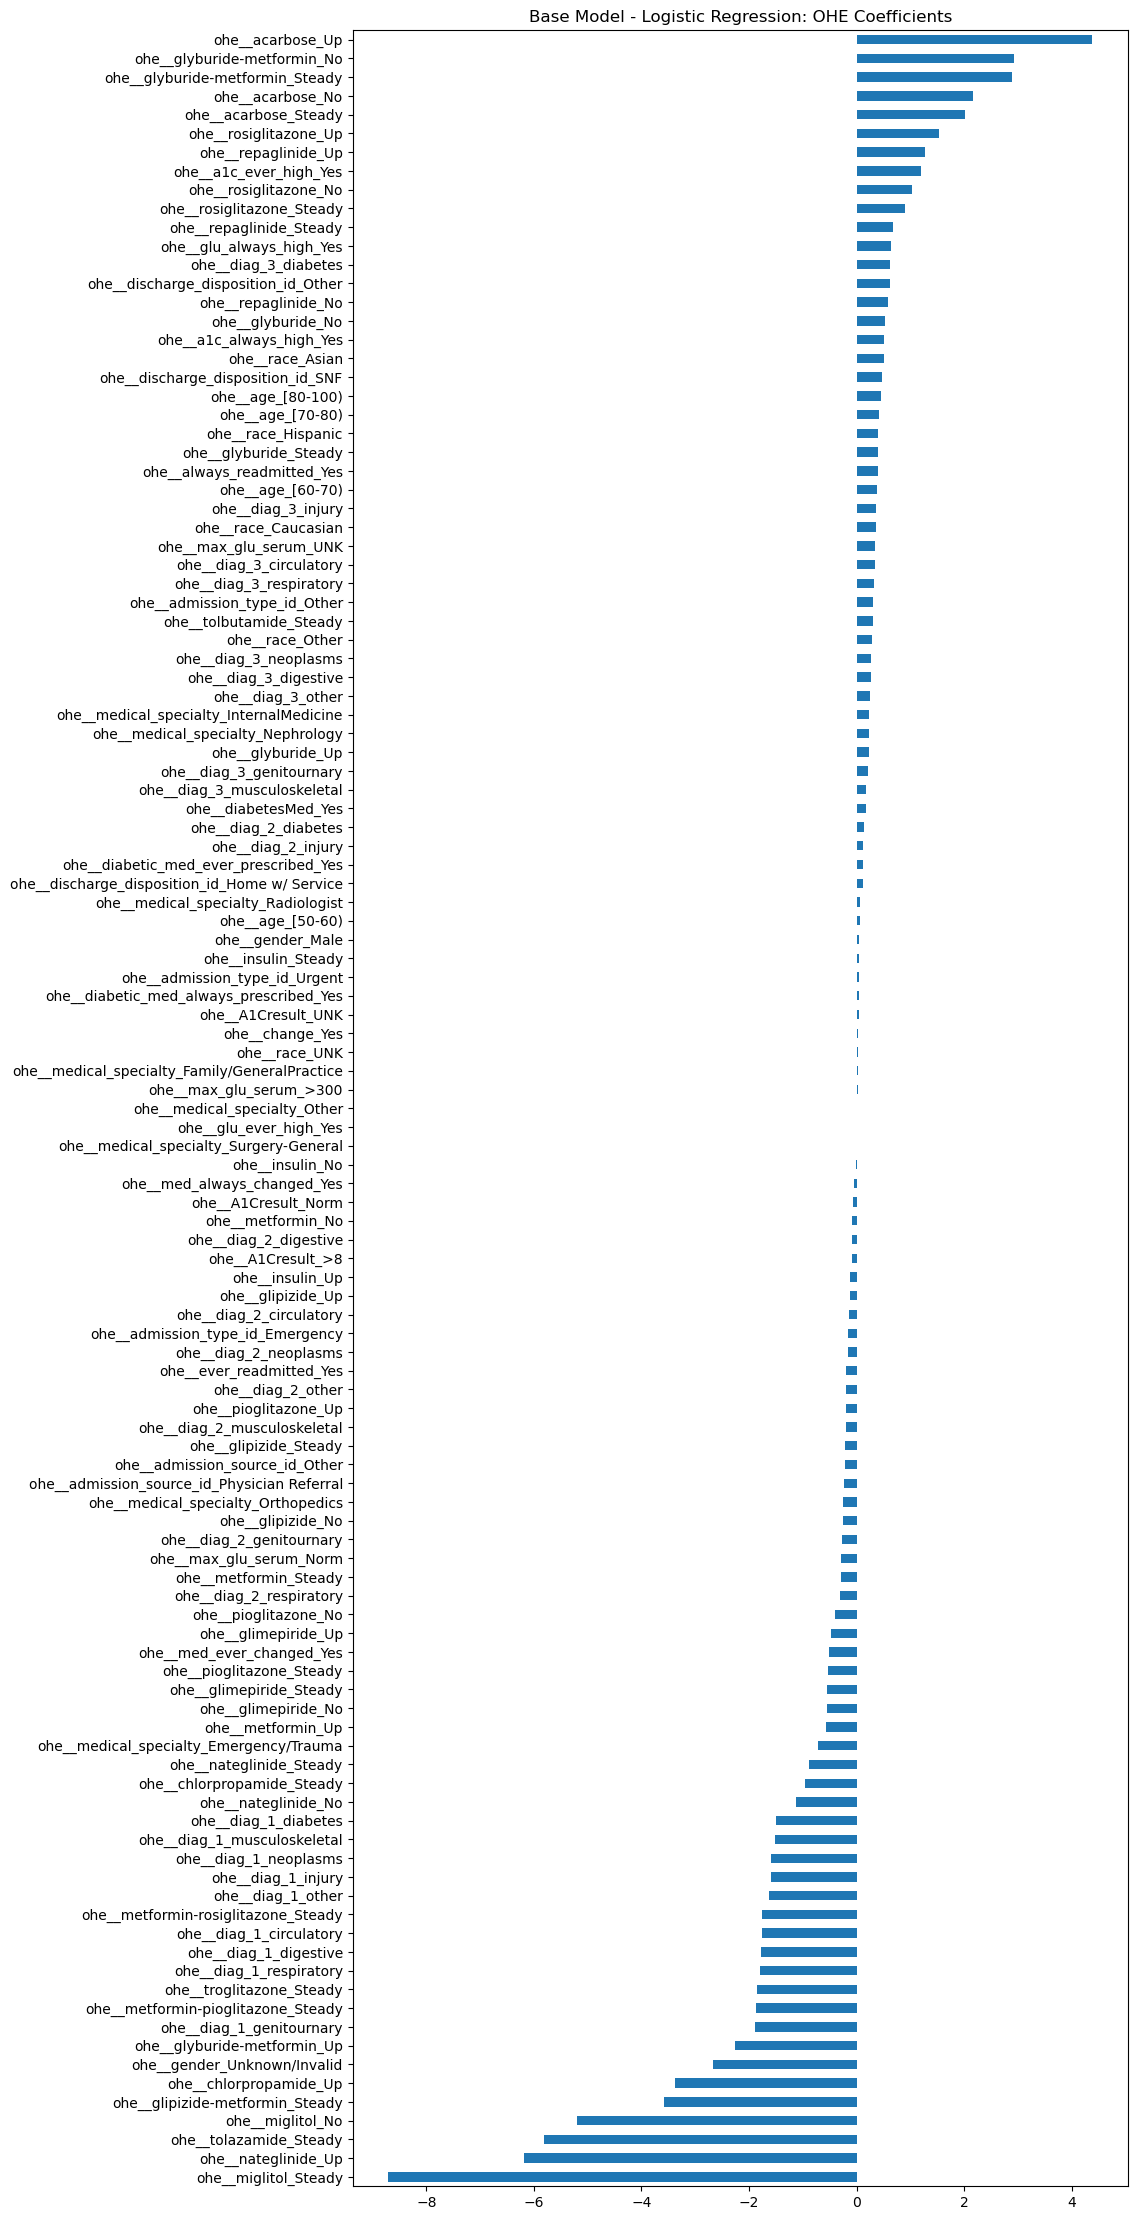

In [29]:
import matplotlib.pyplot as plt

ohe_features = [feature for feature in base_model.feature_names_in_ if feature.startswith('ohe__')]
ohe_coefs    = [coef for feature,coef in zip(base_model.feature_names_in_,base_model.coef_.ravel())
                                             if feature.startswith('ohe__')]

quant_features = [feature for feature in base_model.feature_names_in_ if feature.startswith('quant__')]
quant_coefs    = [coef for feature,coef in zip(base_model.feature_names_in_,base_model.coef_.ravel())
                                             if feature.startswith('quant__')]

plt.figure(figsize=(10,28))
coef = pd.Series(ohe_coefs, index=ohe_features)
_ = coef.sort_values().plot.barh().set_title('Base Model - Logistic Regression: OHE Coefficients')

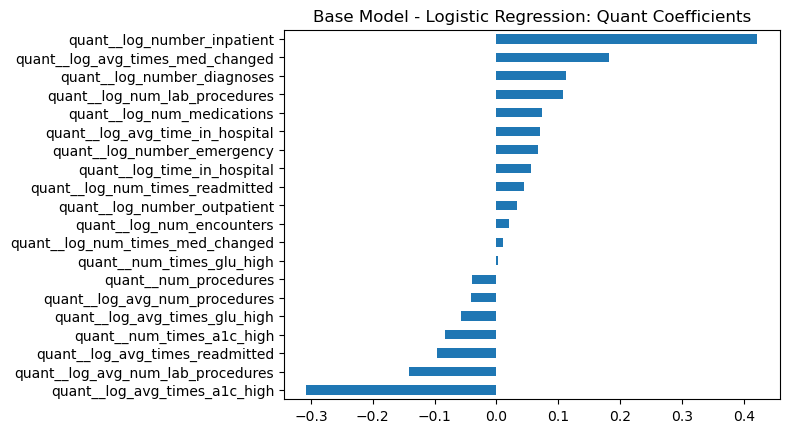

In [30]:
coef = pd.Series(quant_coefs, index=quant_features)
_ = coef.sort_values().plot.barh().set_title('Base Model - Logistic Regression: Quant Coefficients')

**Base Model Results Interpretation**

The train and test accuracies are both 95%, same as the accuracy of naive model which always outputs the majority class.

The base model Logistic Regression results in a test AUC of 0.682; the train AUC is higher at 0.717, indicating some overfitting, which regularization may help reduce.

Calibration: As a secondary metric, we are also intrested in whether the actual predicted probabilities output by the model make sense.  Note that the model without any class weights adjustment is reasonably well calibrated on the test set: average readmitted rate is 0.0502 predicted vs. 0.0496 actual. Model with balanced class weights however is (expectedly) not well calibrated: average readmitted rate now jumps up to 0.4368 on test vs. again actual of 0.0496, with only a marginal gain in test AUC: 0.684 (balanced) vs. 0.682 (unbalanced).

Coefficient Interpretation:
Most important variables in Logistic Regression are the ones with the highest absolute value of coefficients.  The top variables are dominated by changes in dosages of various medications such as miglitol (most important), nateglinide, and others.   Primary diagnosis (reflected as diag1) also seems to be an important predictor.  The derived variable (a1c_ever_high) that measures an important blood test result of A1C for diabetic patients is also important.